## Carparks classification model training
* 15/3/2020
* Notebook to train and export a carpark image classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [41]:
from fastai.vision import *
import torch
from pathlib import Path
import numpy as np

### Setup
* Will be using the pre-cleaned data set where the labels are stored in a csv file
* Using the standard image augmentation transforms, the default settings are appropriate as flip vertical is false by default

In [12]:
path = Path('/media/jjc/data/dataStore/fastai_projects/carparks/')

In [14]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, 
                               folder=".", 
                               valid_pct=0.2, # 20% valdiation set
                               csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), # standard transforms
                               size=224, 
                               num_workers=4).normalize(imagenet_stats)

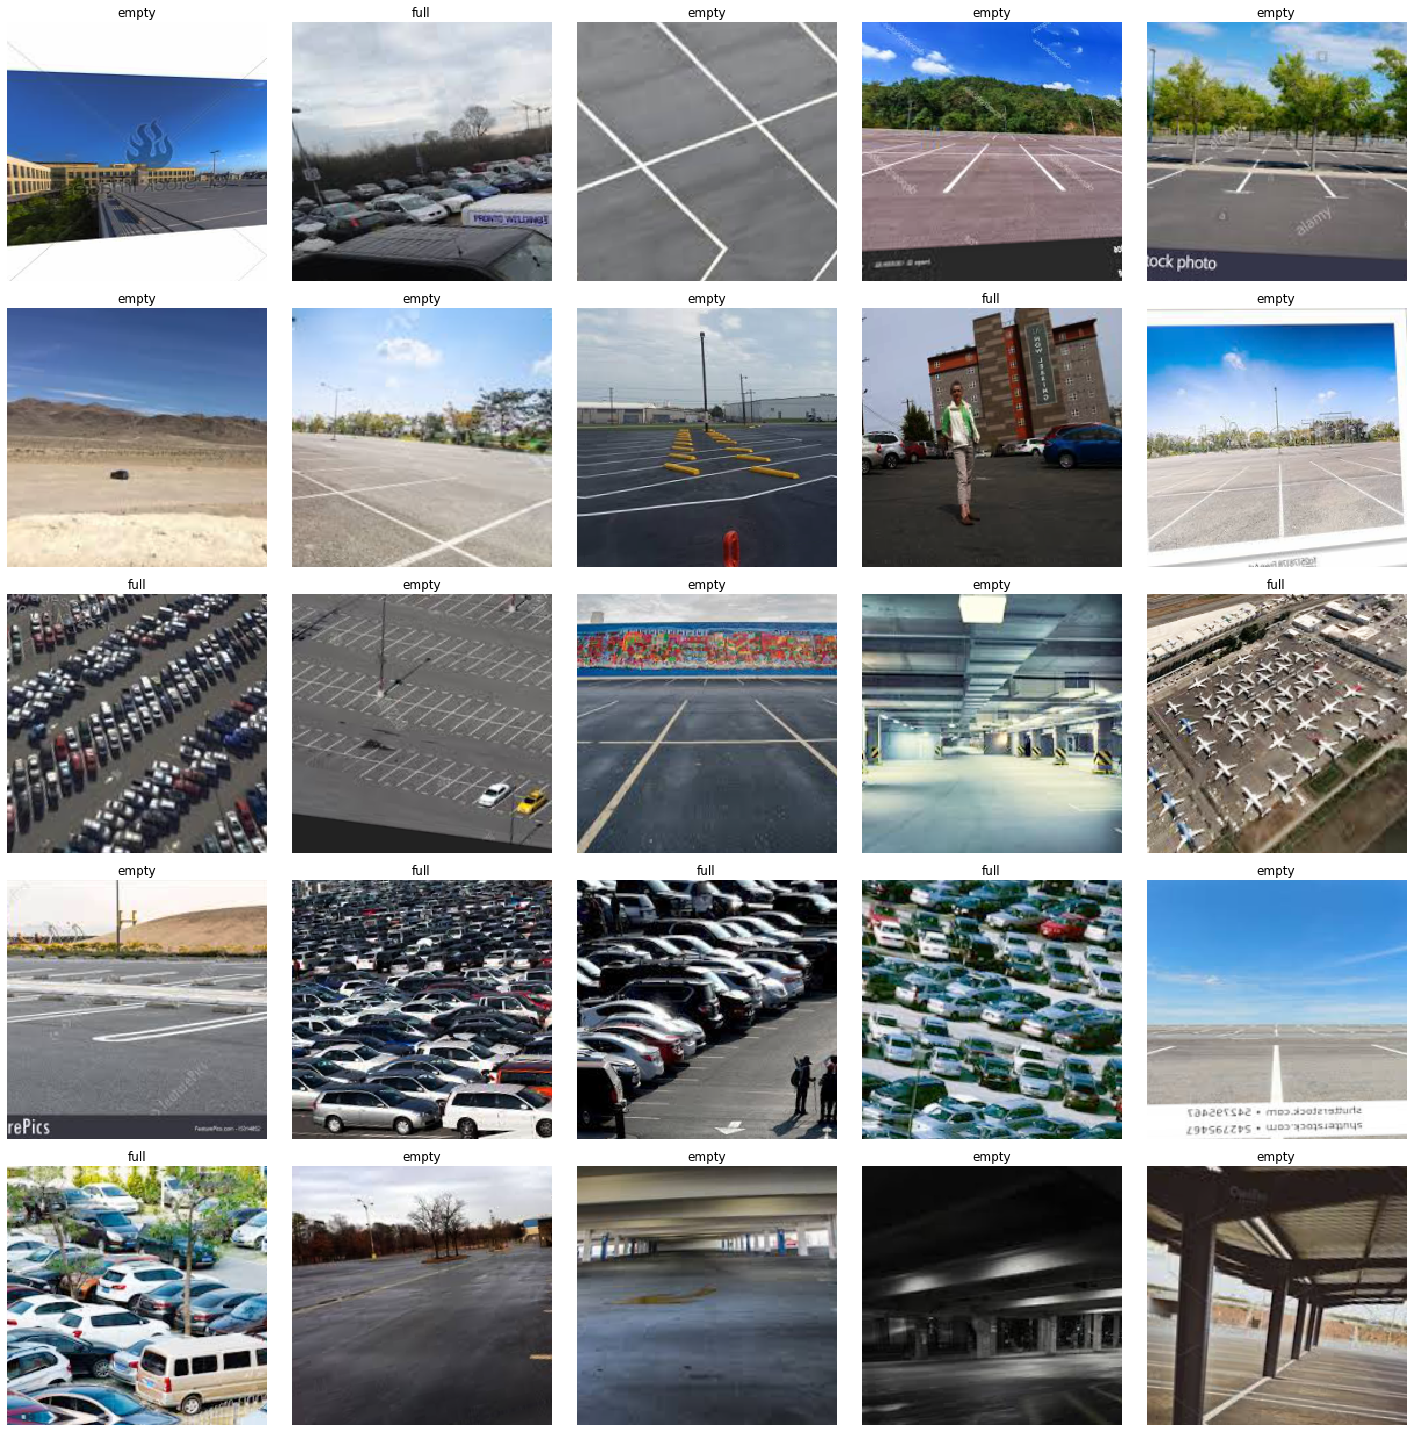

In [15]:
data.show_batch()

### Examine the raw tensors

In [17]:
one_batch = data.one_batch()

In [18]:
# data
one_batch[0].shape

torch.Size([64, 3, 224, 224])

In [20]:
# one image / 3 channels
one_batch[0][0]

tensor([[[0.4682, 0.4682, 0.4660,  ..., 0.3777, 0.3761, 0.3761],
         [0.4690, 0.4691, 0.4681,  ..., 0.3776, 0.3761, 0.3761],
         [0.4698, 0.4693, 0.4691,  ..., 0.3758, 0.3745, 0.3746],
         ...,
         [0.2799, 0.2819, 0.2803,  ..., 0.2408, 0.2405, 0.2477],
         [0.2791, 0.2819, 0.2804,  ..., 0.2394, 0.2395, 0.2448],
         [0.2778, 0.2765, 0.2762,  ..., 0.2417, 0.2417, 0.2437]],

        [[0.6426, 0.6422, 0.6398,  ..., 0.4512, 0.4528, 0.4528],
         [0.6431, 0.6430, 0.6419,  ..., 0.4513, 0.4528, 0.4528],
         [0.6440, 0.6431, 0.6430,  ..., 0.4498, 0.4513, 0.4514],
         ...,
         [0.2724, 0.2744, 0.2728,  ..., 0.2369, 0.2366, 0.2438],
         [0.2716, 0.2744, 0.2729,  ..., 0.2354, 0.2356, 0.2408],
         [0.2703, 0.2689, 0.2687,  ..., 0.2378, 0.2378, 0.2397]],

        [[0.8943, 0.8940, 0.8971,  ..., 0.5945, 0.5945, 0.5945],
         [0.8949, 0.8992, 0.9012,  ..., 0.5945, 0.5945, 0.5945],
         [0.8959, 0.9025, 0.9040,  ..., 0.5916, 0.5930, 0.

In [13]:
# labels
one_batch[1].shape

torch.Size([64])

In [14]:
one_batch[1]

tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

### Create the model and initial train
* Using an RTX card so can benefit from hardware 16bit acceleration and gain a performance benefit from mixed mode training

In [65]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()

epoch     train_loss  valid_loss  error_rate  time    
0         1.216159    #na#        00:00       
1         1.094670    #na#        00:00       
2         1.241619    #na#        00:00       
3         1.341547    #na#        00:00       
4         1.303538    #na#        00:00       
5         1.288140    #na#        00:00       
6         1.278994    #na#        00:00       
7         1.278867    #na#        00:00       
8         1.249060    #na#        00:00       
9         1.242971    #na#        00:00       
10        1.236614    #na#        00:00       
11        1.246656    #na#        00:00       
12        1.220648    #na#        00:00       
13        1.206907    #na#        00:00       
14        1.209334    #na#        00:00       
15        1.200758    #na#        00:00       
16        1.188375    #na#        00:00       
17        1.181788    #na#        00:00       
18        1.177483    #na#        00:00       
19        1.176456    #na#        00:00       
20   

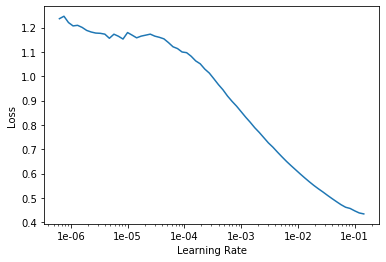

In [59]:
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(6, max_lr=1e-3) # learning rate from the steepest section of the above chart

epoch     train_loss  valid_loss  error_rate  time    
0         1.533547    1.676014    0.517241    00:00     
1         1.320540    1.175967    0.310345    00:00     
2         1.139269    0.829969    0.206897    00:00     
3         0.976183    0.599287    0.172414    00:00     
4         0.828090    0.501571    0.172414    00:00     
5         0.739992    0.462117    0.172414    00:00     


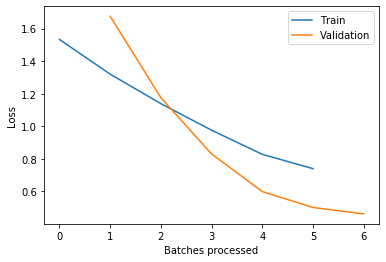

In [67]:
learn.recorder.plot_losses()

In [68]:
learn.save('stage-1')

### Examine mis categorised images

In [69]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()


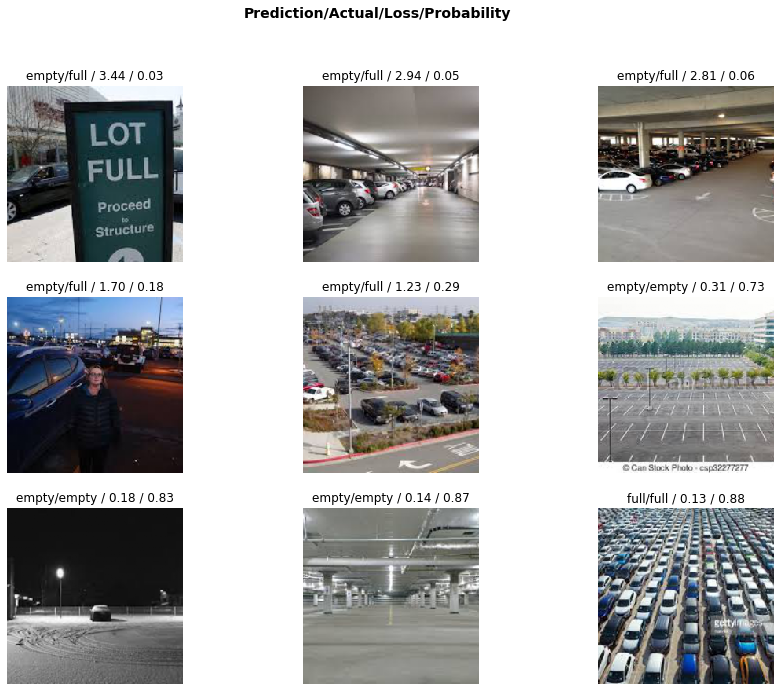

In [70]:
interp.plot_top_losses(9, figsize=(15,11))

### Unfreeze the layers and retrain

In [71]:
learn.unfreeze()

In [72]:
learn.fit_one_cycle(1)

epoch     train_loss  valid_loss  error_rate  time    
0         0.433517    0.359100    0.137931    00:00     


In [73]:
learn.lr_find()

epoch     train_loss  valid_loss  error_rate  time    
0         0.296773    #na#        00:00       
1         0.201935    #na#        00:00       
2         0.223751    #na#        00:00       
3         0.200477    #na#        00:00       
4         0.201435    #na#        00:00       
5         0.212591    #na#        00:00       
6         0.187983    #na#        00:00       
7         0.181095    #na#        00:00       
8         0.182131    #na#        00:00       
9         0.182318    #na#        00:00       
10        0.206602    #na#        00:00       
11        0.200995    #na#        00:00       
12        0.189582    #na#        00:00       
13        0.181847    #na#        00:00       
14        0.182623    #na#        00:00       
15        0.183555    #na#        00:00       
16        0.186539    #na#        00:00       
17        0.194338    #na#        00:00       
18        0.195568    #na#        00:00       
19        0.194558    #na#        00:00       
20   

/home/jjc/anaconda3/envs/fastai_v1/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


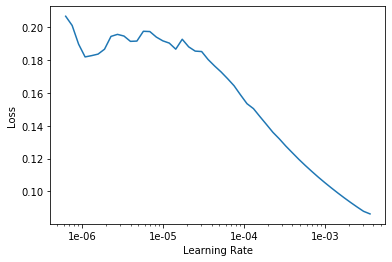

In [74]:
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch     train_loss  valid_loss  error_rate  time    
0         0.089738    0.433689    0.172414    00:00     
1         0.051060    0.214547    0.103448    00:00     
2         0.033807    0.171900    0.103448    00:00     
3         0.026394    0.101646    0.068965    00:00     


### Train on Resnet 50 - see if any improvements can be made

In [79]:
learn50 = cnn_learner(data, models.resnet50, metrics=error_rate).to_fp16()

epoch     train_loss  valid_loss  error_rate  time    
0         1.347931    #na#        00:00       
1         1.203832    #na#        00:00       
2         1.196520    #na#        00:00       
3         1.243445    #na#        00:00       
4         1.279225    #na#        00:00       
5         1.271214    #na#        00:00       
6         1.246224    #na#        00:00       
7         1.254205    #na#        00:00       
8         1.222513    #na#        00:00       
9         1.228288    #na#        00:00       
10        1.220959    #na#        00:00       
11        1.197902    #na#        00:00       
12        1.190960    #na#        00:00       
13        1.200196    #na#        00:00       
14        1.221442    #na#        00:00       
15        1.217109    #na#        00:00       
16        1.221666    #na#        00:00       
17        1.202272    #na#        00:00       
18        1.206598    #na#        00:00       
19        1.199157    #na#        00:00       
20   

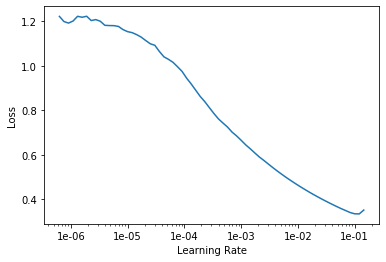

In [80]:
learn50.lr_find()
learn50.recorder.plot()

In [81]:
learn50.fit_one_cycle(8, max_lr=1e-3)

epoch     train_loss  valid_loss  error_rate  time    
0         1.048646    0.659914    0.241379    00:01     
1         0.991384    0.275017    0.103448    00:00     
2         0.859480    0.146416    0.034483    00:00     
3         0.673992    0.163366    0.068965    00:00     
4         0.535080    0.191672    0.068965    00:00     
5         0.459109    0.234689    0.068965    00:00     
6         0.394657    0.261894    0.068965    00:00     
7         0.348861    0.267012    0.068965    00:00     


* Error is oscillating between ~3% and ~6% which I suspect is due to the small dataset and one or two images changing category

In [99]:
# Determine the number of images for each set
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (119 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
empty,empty,empty,empty,empty
Path: /media/jjc/data/dataStore/fastai_projects/carparks;

Valid: LabelList (29 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
full,empty,full,empty,full
Path: /media/jjc/data/dataStore/fastai_projects/carparks;

Test: None>

In [100]:
# error check
print(1/29)
print(1/29 * 2)

0.034482758620689655
0.06896551724137931


Assumption confirmed

In [85]:
learn50.save('stage-1-50')

### Retrain with unfrozen layers

In [87]:
learn50.unfreeze()
learn50.fit_one_cycle(6, max_lr=slice(1e-5,1e-2))

epoch     train_loss  valid_loss  error_rate  time    
0         0.265533    1.905935    0.137931    00:01     
1         0.260013    0.016450    0.000000    00:01     
2         0.196378    0.623987    0.137931    00:01     
3         0.193958    0.000387    0.000000    00:01     
4         0.215425    0.000000    0.000000    00:01     
5         0.190441    0.000069    0.000000    00:01     


We have achieved a perfect model! Suspect again this is due to the small dataset

In [88]:
learn50.save('stage-2-50')

In [89]:
interp = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp.top_losses()

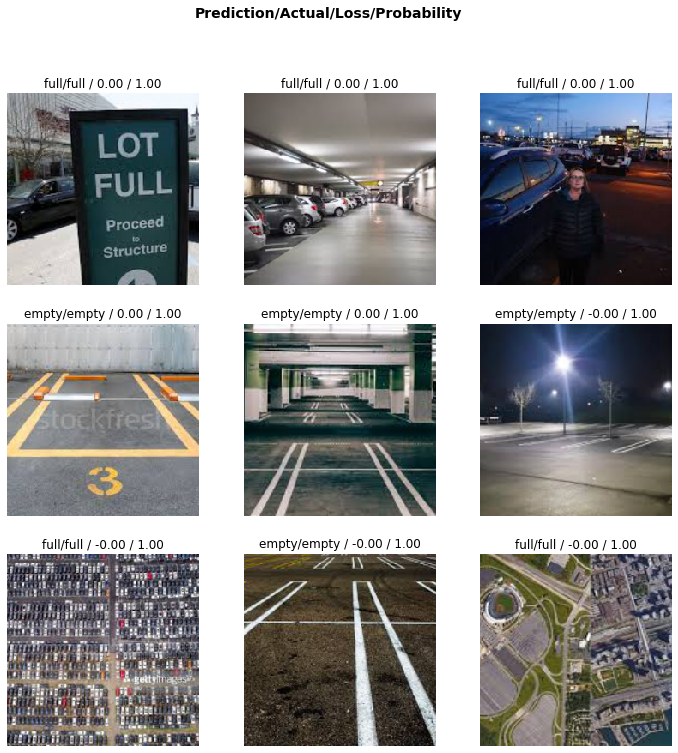

In [90]:
interp.plot_top_losses(9)

### Sanity check on unseen data and export to production model

In [91]:
test_img = open_image(path/'test_images'/'images.jpeg')

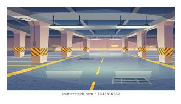

In [93]:
test_img.show()

Interestingly this is a generated image (non photo)

In [95]:

learn50.predict(test_img)


(Category empty, tensor(0), tensor([1.0000e+00, 1.6858e-08]))

In [96]:
learn50.export()